# Introduction

A small neural network with 3 layers:
- Parameter Count: 139
- Layers:
    - Input Layer
        - Function: ReLU
        - Input Size: 4
        - Output Size: 8
    - Hidden Layer
        - Function: ReLU
        - Input Size: 8
        - Output Size: 8
    - Output Layer
        - Function: ReLU
        - Input Size: 8
        - Output Size: 3
        - Softmax and Argmax functions will be applied to the output to determine model's prediction.

Dropout method is used to prevent model from overfitting.


# Setup

In [1]:
# Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

from sklearn.model_selection import train_test_split

In [2]:
# Select device

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


# Prepare Data

In [3]:
# Load data

df = pd.read_csv("../../data/Iris.csv")
df.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


In [4]:
# Drop Id column

df = df.drop(columns=["Id"])

In [5]:
# Seperate features and labels

features = df.drop(columns=["Species"]).values
labels = df["Species"]

In [6]:
# Encode output

labels = pd.get_dummies(labels).astype(int).values

In [7]:
# Train and test splits

X_train, X_val, y_train, y_val = train_test_split(features, labels, test_size=0.2)

In [8]:
# Create tensors

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

In [9]:
# Create datasets

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

In [10]:
# Create dataloaders

BATCH_SIZE = 150
train_dataloader = DataLoader(train_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

val_dataloader = DataLoader(val_dataset,
                            batch_size=BATCH_SIZE,
                            shuffle=True)

In [11]:
print(f'Training dataset size: {len(train_dataset)}')
print(f'Validation dataset size: {len(val_dataset)}')

Training dataset size: 120
Validation dataset size: 30


# Training

In [12]:
# Model

class IrisNet(nn.Module):
    def __init__(self,
                 input_shape: int,
                 hidden_units: int,
                 output_shape: int,
                 dropout = 0.2):
        super().__init__()

        self.linear_stack = nn.Sequential(
            # Input
            nn.Linear(in_features=input_shape,
                      out_features=hidden_units),
            nn.ReLU(),
            nn.Dropout(p=dropout),

            # Hidden
            nn.Linear(in_features=hidden_units,
                      out_features=hidden_units),
            nn.ReLU(),
            nn.Dropout(p=dropout),

            # Output
            nn.Linear(in_features=hidden_units,
                      out_features=output_shape),
        )

    def forward(self, x):
        return self.linear_stack(x)

In [13]:
def train_step(model: nn.Module,
               dataloader: torch.utils.data.DataLoader,
               criterion: nn.Module,
               optimizer: torch.optim.Optimizer,
               device=device):
    model.train()

    train_loss = 0.0
    train_acc = 0.0

    for batch, (X, y) in enumerate(dataloader):
        X = X.to(device)
        y = y.to(device)

        # Forward pass
        y_logits = model(X)
        y_pred_probs = torch.softmax(y_logits, 0)

        # Loss and accuracy
        loss = criterion(y_logits, y)
        train_loss += loss

        train_acc += (torch.argmax(y_pred_probs, dim=1) == torch.argmax(y)).sum().item() /len(y_pred_probs)

        # Optimizer
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # Find average loss and accuracy
    train_loss /= len(dataloader)
    train_acc /= len(dataloader)

    return train_loss, train_acc

In [14]:
def test_step(model: nn.Module,
              dataloader: torch.utils.data.DataLoader,
              criterion: nn.Module,
              device=device):
    model.eval()

    test_loss = 0.0
    test_acc = 0.0

    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X = X.to(device)
            y = y.to(device)

            # Forward pass
            y_logits = model(X)
            y_pred_probs = torch.softmax(y_logits, 0)

            # Loss and accuracy
            loss = criterion(y_logits, y)
            test_loss += loss

            test_acc += (torch.argmax(y_pred_probs, dim=1) == torch.argmax(y)).sum().item() / len(y_pred_probs)
        
        # Find average loss and accuracy
        test_loss /= len(dataloader)
        test_acc /= len(dataloader)
    
    return test_loss, test_acc

In [15]:
model = IrisNet(input_shape=features.shape[1],
                hidden_units=8,
                output_shape=labels.shape[1],
                dropout=0.2).to(device)
model

IrisNet(
  (linear_stack): Sequential(
    (0): Linear(in_features=4, out_features=8, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=8, out_features=8, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=8, out_features=3, bias=True)
  )
)

In [35]:
model_parameter_count = sum(p.numel() for p in model.parameters())
print(f"Parameter count: {model_parameter_count}")

Parameter count: 139


In [16]:
# Initialize loss functiıon/optimizer

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(),
                             lr=0.0005)

In [17]:
# Initialize metrics

metrics = {}
metrics["model"] = str(model)
metrics["train_losses"] = []
metrics["train_accuracies"] = []
metrics["test_losses"] = []
metrics["test_accuracies"] = []

metrics

{'model': 'IrisNet(\n  (linear_stack): Sequential(\n    (0): Linear(in_features=4, out_features=8, bias=True)\n    (1): ReLU()\n    (2): Dropout(p=0.2, inplace=False)\n    (3): Linear(in_features=8, out_features=8, bias=True)\n    (4): ReLU()\n    (5): Dropout(p=0.2, inplace=False)\n    (6): Linear(in_features=8, out_features=3, bias=True)\n  )\n)',
 'train_losses': [],
 'train_accuracies': [],
 'test_losses': [],
 'test_accuracies': []}

In [18]:
# Training loop

epochs = 1000
epoch_print_interval = epochs / 10

for epoch in range(epochs):
    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_dataloader,
                                       criterion=criterion,
                                       optimizer=optimizer,
                                       device=device)
    
    test_loss, test_acc = test_step(model=model,
                                    dataloader=val_dataloader,
                                    criterion=criterion,
                                    device=device)
    
    metrics["train_losses"].append(train_loss.item())
    metrics["train_accuracies"].append(train_acc)
    metrics["test_losses"].append(test_loss.item())
    metrics["test_accuracies"].append(test_acc)

    if epoch % epoch_print_interval == 0 or epoch == epochs-1:
        print(f"Epoch: {epoch} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}% | Test Loss: {test_loss:.4f} | Test Acc: {test_acc*100:.2f}%")

Epoch: 0 | Train Loss: 1.3043 | Train Acc: 33.33% | Test Loss: 1.4182 | Test Acc: 40.00%
Epoch: 100 | Train Loss: 0.9721 | Train Acc: 30.00% | Test Loss: 0.9443 | Test Acc: 46.67%
Epoch: 200 | Train Loss: 0.8448 | Train Acc: 28.33% | Test Loss: 0.7921 | Test Acc: 46.67%
Epoch: 300 | Train Loss: 0.7258 | Train Acc: 31.67% | Test Loss: 0.6468 | Test Acc: 16.67%
Epoch: 400 | Train Loss: 0.7145 | Train Acc: 35.00% | Test Loss: 0.5106 | Test Acc: 46.67%
Epoch: 500 | Train Loss: 0.5661 | Train Acc: 28.33% | Test Loss: 0.3768 | Test Acc: 16.67%
Epoch: 600 | Train Loss: 0.5242 | Train Acc: 44.17% | Test Loss: 0.3290 | Test Acc: 16.67%
Epoch: 700 | Train Loss: 0.4758 | Train Acc: 25.00% | Test Loss: 0.2961 | Test Acc: 33.33%
Epoch: 800 | Train Loss: 0.4501 | Train Acc: 24.17% | Test Loss: 0.2601 | Test Acc: 23.33%
Epoch: 900 | Train Loss: 0.3924 | Train Acc: 28.33% | Test Loss: 0.2259 | Test Acc: 46.67%
Epoch: 999 | Train Loss: 0.3668 | Train Acc: 17.50% | Test Loss: 0.1997 | Test Acc: 30.00%


In [19]:
def plot_metrics(metrics: dict):
    x = range(0, len(metrics["train_losses"]))

    plt.figure(figsize=(15, 6))

    plt.subplot(2, 1, 1)
    plt.title("Loss")
    plt.plot(x, metrics["train_losses"], label="Train Losses")
    plt.plot(x, metrics["test_losses"], label="Test Losses")
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.title("Accuracy")
    plt.plot(x, metrics["train_accuracies"], label="Train Accuracies")
    plt.plot(x, metrics["test_accuracies"], label="Test Accuracies")
    plt.legend()

    plt.show()

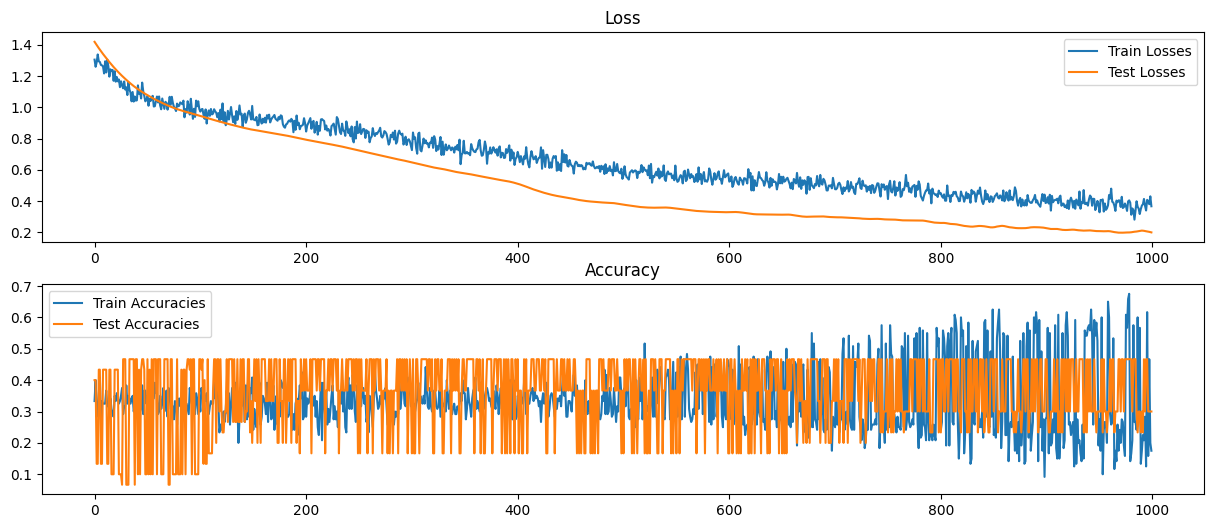

In [20]:
plot_metrics(metrics)

In [28]:
print(f"Lowest loss on test dataset: {min(metrics['test_losses']):.6f}")
print(f"Highest accuracy on test dataset: {max(metrics['test_accuracies'])*100:.4f}%")

Lowest loss on test dataset: 0.197494
Highest accuracy on test dataset: 46.6667%


# Conclusion

It seems like the neural network struggles on this dataset. While we can achieve lower losses, accuracy doesn't seem to improve.

Increasing layer size and count doesn't seem to make a difference either.

Metrics:
- Lowest achieved loss on the test dataset: 0.197494
- Highest achieved accuracy on the test dataset: 46.6667%